# Phong Shading


Gouraud shading의 한계를 극복할 수는 있지만 그에 따른 trade-off가 존재한다. (퀄리티와 비용 사이) \
다른 shading의 종류인 "Flat Shading"은 삼각형당 단일 조도 계산을 한다. 효율적이지만 퀄리티는 낮다. \
"Gouraud shading"은 삼각형당 세 번의 조명 계산과 더불어 삼각형 전체에 걸쳐 단일 속성인 조명을 보간(interpolation)해야한다.


좋은 품질을 위해서는 삼각형의 모든 픽셀에서 조명을 계산해야한다.

이는 이론적으로는 그다지 어려워 보이지는 않지만 현재 우리는 라이팅을 할 때 삼각형의 각 3개의 꼭짓점을 이용한다.  

[<__main__.Light object at 0x00000276489E76A0>, <__main__.Light object at 0x0000027644BB7070>, <__main__.Light object at 0x00000276489E77C0>]


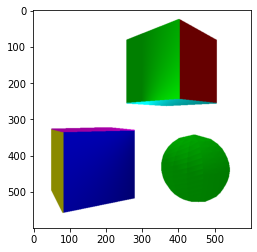

In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import copy



def rotation_matrix(orientation):
    x_rotate = np.array([[1, 0, 0, 0],
                   [0, math.cos(math.pi * orientation[0] / 180), (math.sin(math.pi * orientation[0] / 180)), 0],
                   [0, -(math.sin(math.pi * orientation[0] / 180)), math.cos(math.pi * orientation[0] / 180), 0],
                    [0, 0, 0, 1]])
    y_rotate = np.array([[math.cos(math.pi * orientation[1] / 180),0,-(math.sin(math.pi * orientation[1] / 180)), 0],
               [0, 1, 0, 0],
               [(math.sin(math.pi * orientation[1] / 180)), 0, math.cos(math.pi * orientation[1] / 180), 0],
                [0, 0, 0, 1]])
    z_rotate = np.array([[math.cos(math.pi * orientation[2] / 180), (math.sin(math.pi * orientation[2] / 180)), 0, 0],
               [-(math.sin(math.pi * orientation[2] / 180)), math.cos(math.pi * orientation[2] / 180), 0, 0],
               [0, 0, 1, 0],
                [0, 0, 0, 1]])
    
    return np.dot(np.dot(x_rotate, y_rotate), z_rotate)

def translate_matrix(position):
    return np.array([[1, 0, 0, position[0]],
                   [0, 1, 0, position[1]],
                   [0, 0, 1, position[2]],
                   [0, 0, 0, 1]])

def scale_matrix(scale):
    return np.array([[scale, 0, 0, 0],
                    [0, scale, 0, 0],
                    [0, 0, scale, 0],
                    [0, 0, 0, 1]])

class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color
        
class Vertex:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
class Vertex4:
    def __init__(self, x, y, z, w):
        self.x = x
        self.y = y
        self.z = z
        self.w = w

class Triangle:
    def __init__(self, v,color = (255,255,255), normals = None):
        self.v = v
        self.color = color
        self.normals = normals
class Camera:
    def __init__(self,
                 position = [0,0,0],
                 orientation = [0,0,0],
                 viewport_size = 1,
                 projection_plane_z = 1
                 ):
        
        self.position = position
        self.orientation = orientation
        self.viewport_size = viewport_size
        self.projection_plane_z = projection_plane_z
        
class Scene:
    def __init__(self,
                 instances):
        self.instances = instances
        self.lights = []
        
class Light:
    def __init__(self, ltype, intensity, position=None, direction=None):
        self.ltype = ltype
        self.intensity = intensity
        self.position = np.array(position)
        self.direction = np.array(direction)
        
class Model:
    def __init__(self, vertices, triangles):
        self.vertices = vertices
        self.triangles = triangles

class Sphere:
    def __init__(self, center, radius):
        self.center = center
        self.radius = radius
        
class Instance:
    def __init__(self, model, position=[0,0,0], orientation=[0,0,0], scale=1, bounding_sphere = None):
        self.model = model
        self.position = position
        self.orientation = orientation
        self.scale = scale
        
        self.transform = np.dot(translate_matrix(self.position), np.dot(rotation_matrix(self.orientation), scale_matrix(self.scale)))
        
        self.bounding_sphere = bounding_sphere
        
        
class Plane:
    def __init__(self, normal, distance=0):
        self.normal = normal
        self.distance = distance
        
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width=1):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        
        
class Renderer:
    def __init__(self, camera, canvas, scene):
        self.camera = camera
        self.canvas = canvas
        self.scene = scene
        self.depth_buffer = [[float('inf') for j in range(canvas.width)] for i in range(canvas.height)]
        
    def draw_line(self, p0, p1, color, line_width=1):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                canvas.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                canvas.put_pixel(xs[i], i+p0.y, color, line_width)
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i0, i1+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width = 1):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width = 1, z = None):
        
        if z == None:
            # Sort the points so that y0 <= y1 <= y2
            if p1.y < p0.y:
                p1, p0 = p0, p1
            if p2.y < p0.y:
                p2, p0 = p0, p2
            if p2.y < p1.y:
                p1, p2 = p2, p1

            # Compute the x coordinates of the triangle edges
            x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
            x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
            x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)

            # Concatenate the short sides
            x01.pop(-1)
            x012 = x01 + x12

            # Determine which is left and which is right
            m = math.floor(len(x012)/2)
            if x02[m] < x012[m]:
                x_left = x02
                x_right= x012
            else:
                x_left = x012
                x_right = x02

            # Draw the horizontal segments
            for y in range(p0.y,p2.y):
                x_left_value = math.floor(x_left[y-p0.y])
                x_right_value = math.floor(x_right[y-p0.y])
                for x in range(x_left_value, x_right_value+1):
                    canvas.put_pixel(x,y,color,line_width)
                    
        else:
            # Sort the points so that y0 <= y1 <= y2
            if p1.y < p0.y:
                p1, p0 = p0, p1
                z[1], z[0] = z[0], z[1]
            if p2.y < p0.y:
                p2, p0 = p0, p2
                z[2], z[0] = z[0], z[2]
            if p2.y < p1.y:
                p1, p2 = p2, p1
                z[1], z[2] = z[2], z[1]

            # Compute the x coordinates of the triangle edges
            x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
            x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
            x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
            
            z01 = self.interpolate(p0.y, z[0], p1.y, z[1])
            z12 = self.interpolate(p1.y, z[1], p2.y, z[2])
            z02 = self.interpolate(p0.y, z[0], p2.y, z[2])

            # Concatenate the short sides
            x01.pop(-1)
            x012 = x01 + x12
            
            z01.pop(-1)
            z012 = z01 + z12
            
            # Determine which is left and which is right
            m = math.floor(len(x012)/2)
            if x02[m] < x012[m]:
                x_left = x02
                x_right= x012
                
                z_left = z02
                z_right= z012
            else:
                x_left = x012
                x_right = x02
                
                z_left = z012
                z_right = z02
                
            # Draw the horizontal segments
            for y in range(p0.y,p2.y):
                x_l = math.floor(x_left[y-p0.y])
                x_r= math.floor(x_right[y-p0.y])
                
                z_segment = self.interpolate(x_l, z_left[y - p0.y], x_r, z_right[y - p0.y])
                for x in range(x_l, x_r+1):
                    z = z_segment[x - x_l]
                    if z < self.depth_buffer[x][y]:
                        canvas.put_pixel(x,y,color,line_width)
                        self.depth_buffer[x][y] = z
                        
    def compute_lighting(self, point, normal, view, specular):
        lights = self.scene.lights
        
        intensity = 0
        
        length_n = np.linalg.norm(normal)
        length_v = np.linalg.norm(view)
        
        vec_normal = normal/length_n
        vec_view = view/ length_v
        
        length_n = np.linalg.norm(vec_normal)
        length_v = np.linalg.norm(vec_view)
        
        for i, light in enumerate(lights):
            if light.ltype == 0:
                intensity += light.intensity
            else :
                vec_l = []
                if light.ltype == 1:
                    vec_l = np.subtract(light.position, point)
                else :  #DIRECTIONAL
                    vec_l = light.direction
                
                # Diffuse reflection.
                n_dot_l = np.dot(vec_normal, vec_l)
                if( n_dot_l > 0) :
                    intensity += light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l))
                    # print(light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l)))


                # Specular reflection.
                if (specular != -1 ):
                    vec_r = self.reflect_ray(vec_l, vec_normal)
                    #vec_r = 2 * normal * np.dot(normal, vec_l) - vec_l
                    # vec_r = np.subtract(np.multiply(2.0*np.dot(normal, vec_l), normal), vec_l)
                    r_dot_v = np.dot(vec_r, vec_view)
                    if (r_dot_v > 0):
                        intensity += light.intensity * math.pow(r_dot_v / (np.linalg.norm(vec_r) * length_v), specular)
                        # print(light.intensity * math.pow(r_dot_v / (np.linalg.norm(vec_r) * length_v), specular))
        # print(intensity)
        
        if intensity > 1:
            intensity = 1
            
        return np.array(intensity)
    
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width, z : list, normals: list): # z가 파라미터로 추가됨 
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        '''
            for gouraud shading 
                need: 
                    normal of each vertex
                return:
                    intencity or h of every vertex 
                    
            for phong
                need: 
                    lights
                    normal vector of each 
                return: 
                
        '''
        c_pos = self.camera.position
        
        n0 = normals[0]
        n1 = normals[1]
        n2 = normals[2]
        
        ps = [p0, p1, p2]
        
        d = camera.projection_plane_z
        # print('========================')
        for i in range(3):
            zc = z[i]
            xc = ps[i].x/d*zc / (canvas.width / camera.viewport_size)
            yc = ps[i].y/d*zc / (canvas.height / camera.viewport_size)
            
            
            # change camera coord to world coord
            xw, yw, zw = self.apply_camera_inv_mat(xc, yc, zc)
            
            
            nx = normals[i].x
            ny = normals[i].y
            nz = normals[i].z
            
            p = np.array([xw,yw,zw])
            vec_normal = np.array([nx,ny,nz])
            vec_view = np.array([c_pos[0]-xw,
                                 c_pos[1]-yw,
                                 c_pos[2]-zw])
            
            
            ps[i].h = self.compute_lighting(p, vec_normal, vec_view, specular=10)
            # print('---------------------------------')
            # print(p)
            # print(vec_normal)
            # print(vec_view)
            # print(ps[i].h)


        
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l]) 
                canvas.put_pixel(x,y,shaded_color,line_width)        
        # print([p.h for p in ps])
        return
                
    def draw_shaded_triangle_phong(self, p0, p1, p2, color, line_width, z : list, normals: list): # z가 파라미터로 추가됨 
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        '''
            for gouraud shading 
                need: 
                    normal of each vertex
                return:
                    intencity or h of every vertex 
                    
            for phong
                need: 
                    lights
                    normal vector of each 
                return: 
                
        '''
        c_pos = self.camera.position
        
        n0 = normals[0]
        n1 = normals[1]
        n2 = normals[2]
        
        # As Y set as the independent variable interpolate the below
        # x, normal(x,y,z), z
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        nx01 = self.interpolate(p0.y, n0.x, p1.y, n1.x)
        ny01 = self.interpolate(p0.y, n0.y, p1.y, n1.y)
        nz01 = self.interpolate(p0.y, n0.z, p1.y, n1.z)
        z01 = self.interpolate(p0.y, z[0], p1.y, z[1])
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        nx12 = self.interpolate(p1.y, n1.x, p2.y, n2.x)
        ny12 = self.interpolate(p1.y, n1.y, p2.y, n2.y)
        nz12 = self.interpolate(p1.y, n1.z, p2.y, n2.z)
        z12 = self.interpolate(p1.y, z[1], p2.y, z[2])
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        nx02 = self.interpolate(p0.y, n0.x, p2.y, n2.x)
        ny02 = self.interpolate(p0.y, n0.y, p2.y, n2.y)
        nz02 = self.interpolate(p0.y, n0.z, p2.y, n2.z)
        z02 = self.interpolate(p0.y, z[0], p2.y, z[2])
        
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        nx01.pop(-1)
        nx012 = nx01 + nx12
        
        ny01.pop(-1)
        ny012 = ny01 + ny12
        
        nz01.pop(-1)
        nz012 = nz01 + nz12
        
        z01.pop(-1)
        z012 = z01 + z12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            nx_left = nx02
            ny_left = ny02
            nz_left = nz02
            z_left = z02
            
            x_right= x012
            nx_right= nx012
            ny_right= ny012
            nz_right= nz012
            z_right= z012
        else:
            x_left = x012
            nx_left = nx012
            ny_left = ny012
            nz_left = nz012
            z_left = z012
            
            x_right= x02
            nx_right= nx02
            ny_right= ny02
            nz_right= nz02
            z_right= z02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            nx_segment = self.interpolate(x_l, nx_left[y - p0.y], x_r, nx_right[y - p0.y])
            ny_segment = self.interpolate(x_l, ny_left[y - p0.y], x_r, ny_right[y - p0.y])
            nz_segment = self.interpolate(x_l, nz_left[y - p0.y], x_r, nz_right[y - p0.y])
            z_segment = self.interpolate(x_l, z_left[y - p0.y], x_r, z_right[y - p0.y])
            
            for x in range(x_l, x_r + 1):
                d = camera.projection_plane_z
                
                xc = x/d*z_segment[x - x_l]
                yc = y/d*z_segment[x - x_l]
                z = z_segment[x - x_l]
                
                xw,yw,zw = self.apply_camera_inv_mat(xc, yc, z)
                
                nx = nx_segment[x - x_l]
                ny = ny_segment[x - x_l]
                nz = nz_segment[x - x_l]
                
                p = np.array([xw,yw,zw])
                vec_normal = np.array([nx,ny,nz])
                vec_view = np.array([c_pos[0]-xw,
                                     c_pos[1]-yw,
                                     c_pos[2]-zw])

                intencity = self.compute_lighting(p, vec_normal, vec_view, specular=10)
                
                shaded_color = intencity * color
                canvas.put_pixel(x,y,shaded_color,line_width)
    
    def reflect_ray(self,R,N):
        return 2 * N * np.dot(N, R) - R
    
    def apply_camera_inv_mat(self,x_c,y_c,z_c):
        vertex_h = Vertex4(x_c, y_c, z_c, 1)
        camera_inv_matrix = np.dot( translate_matrix(self.camera.position),rotation_matrix(self.camera.orientation))
        transformed_v = np.dot(camera_inv_matrix, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))
        
        return transformed_v[0], transformed_v[1], transformed_v[2]
        
        #     def transform_instance(self):
        # camera_matrix = np.dot(rotation_matrix(self.camera.orientation).T, translate_matrix(np.dot(-1, self.camera.position)))
        # for instance in self.scene.instances:
        #     transform = np.dot(camera_matrix, instance.transform)
            
        #     sum_vertex = [0,0,0]
        #     for vertex in instance.model.vertices:
        #         vertex_h = Vertex4(vertex.x, vertex.y, vertex.z, 1)
        #         transformed_v = np.dot(transform, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))
        #         vertex.x = transformed_v[0]
        #         vertex.y = transformed_v[1]
        #         vertex.z = transformed_v[2]
            
        #         sum_vertex[0] += transformed_v[0]
        #         sum_vertex[1] += transformed_v[1]
        #         sum_vertex[2] += transformed_v[2]
                
        #     center = Vertex(sum_vertex[0] / len(instance.model.vertices), 
        #                     sum_vertex[1] / len(instance.model.vertices),
        #                     sum_vertex[2] / len(instance.model.vertices))
            
        #     instance.bounding_sphere.center = center

    def viewport_to_canvas(self, x, y):
        p = Point(int(x * (canvas.width / camera.viewport_size)), int(y * (canvas.height / camera.viewport_size)), h =1.0)
        return p
    
    def project_vertex(self, v):
        d = camera.projection_plane_z
        return self.viewport_to_canvas(v[0] * d / v[2], v[1] * d / v[2])
    
    def render_triangle(self,inst, model, triangle, projected, z=None):
        mode=0
        
        new_norm = self.model_coord_to_wrld_coord(inst, triangle.normals)
        
        if z == None:
            self.draw_wire_triangle(projected[triangle.v[0]],
                               projected[triangle.v[1]],
                               projected[triangle.v[2]],
                               triangle.color)
        elif mode==0:
            self.draw_shaded_triangle_phong(projected[triangle.v[0]],
                                      projected[triangle.v[1]],
                                      projected[triangle.v[2]],
                                      triangle.color,2, z=z, normals= new_norm)
        else:
            self.draw_shaded_triangle(projected[triangle.v[0]],
                                      projected[triangle.v[1]],
                                      projected[triangle.v[2]],
                                      triangle.color,2, z=z, normals= new_norm)
            
    def model_coord_to_wrld_coord(self, inst, normals):
        transform = inst.transform
        calced_normals = []
        curr_normal = None
        
        for i, norm in enumerate(normals):
            vertex_h = Vertex4(norm.x, norm.y, norm.z, 0)
            curr_normal = np.dot(transform, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))
            
            curr_normal = Vertex(curr_normal[0], curr_normal[1], curr_normal[2])
            calced_normals.append(curr_normal)
            
        return calced_normals
            
        #         def transform_instance(self):
        # camera_matrix = np.dot(rotation_matrix(self.camera.orientation).T, translate_matrix(np.dot(-1, self.camera.position)))
        # for instance in self.scene.instances:
        #     transform = np.dot(camera_matrix, instance.transform)
            
        #     sum_vertex = [0,0,0]
        #     for vertex in instance.model.vertices:
        #         vertex_h = Vertex4(vertex.x, vertex.y, vertex.z, 1)
        #         transformed_v = np.dot(transform, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))
        #         vertex.x = transformed_v[0]
        #         vertex.y = transformed_v[1]
        #         vertex.z = transformed_v[2]
            
        #         sum_vertex[0] += transformed_v[0]
        #         sum_vertex[1] += transformed_v[1]
        #         sum_vertex[2] += transformed_v[2]
                
        #     center = Vertex(sum_vertex[0] / len(instance.model.vertices),
        #                     sum_vertex[1] / len(instance.model.vertices),
        #                     sum_vertex[2] / len(instance.model.vertices))
            
        
    # for clipping
    def render_model(self,inst, model):
        projected = []
        for vertex in model.vertices:
            v = [vertex.x, vertex.y, vertex.z]
            projected.append(self.project_vertex(v))
            
        for triangle in model.triangles:
            z_positions = [model.vertices[triangle.v[0]].z,
                           model.vertices[triangle.v[1]].z, 
                           model.vertices[triangle.v[2]].z]
            
            self.render_triangle(inst, model, triangle, projected, z=z_positions)
    
    def direction_of_normal_vector(self, instance, triangle):
        A = np.array([instance.model.vertices[triangle.v[0]].x,
             instance.model.vertices[triangle.v[0]].y,
             instance.model.vertices[triangle.v[0]].z])
        
        B = np.array([instance.model.vertices[triangle.v[1]].x,
             instance.model.vertices[triangle.v[1]].y,
             instance.model.vertices[triangle.v[1]].z])
        
        C = np.array([instance.model.vertices[triangle.v[2]].x,
             instance.model.vertices[triangle.v[2]].y,
             instance.model.vertices[triangle.v[2]].z])
        
        V = (A + B + C) / 3
        
        v1 = B - A
        v2 = C - A
        
        normal = np.cross(v1,v2)
        
        return normal, V
    
    def cull_back_faces(self, instance):
        front_face_triangles = []
        for triangle in instance.model.triangles:
            normal, V = self.direction_of_normal_vector(instance, triangle)
            if np.dot(normal, -V) > 0:
                front_face_triangles.append(triangle)
                
        instance.model.triangles = front_face_triangles
        
    def render_scene(self):
        for instance in self.scene.instances:
            self.cull_back_faces(instance)
            self.render_model(instance, instance.model)
            
    def show(self):
        plt.imshow(self.canvas.img)
        return
    
class Clipper:
    def __init__(self, camera, scene):
        self.camera = camera
        self.scene = scene
        
    def transform_instance(self):
        camera_matrix = np.dot(rotation_matrix(self.camera.orientation).T, translate_matrix(np.dot(-1, self.camera.position)))
        for instance in self.scene.instances:
            transform = np.dot(camera_matrix, instance.transform)
            
            sum_vertex = [0,0,0]
            for vertex in instance.model.vertices:
                vertex_h = Vertex4(vertex.x, vertex.y, vertex.z, 1)
                transformed_v = np.dot(transform, np.array([vertex_h.x, vertex_h.y, vertex_h.z, vertex_h.w]))
                vertex.x = transformed_v[0]
                vertex.y = transformed_v[1]
                vertex.z = transformed_v[2]
            
                sum_vertex[0] += transformed_v[0]
                sum_vertex[1] += transformed_v[1]
                sum_vertex[2] += transformed_v[2]
                
            center = Vertex(sum_vertex[0] / len(instance.model.vertices),
                            sum_vertex[1] / len(instance.model.vertices),
                            sum_vertex[2] / len(instance.model.vertices))
            
            instance.bounding_sphere.center = center
            
    def signed_distance(self, plane, vertex):
        normal = plane.normal
        
        return ((vertex.x * normal.x) + 
                (vertex.y * normal.y) + 
                (vertex.z * normal.z) + plane.distance)
    
    def intersect_plane(self, a, b, plane):
        plane_normal = np.array([plane.normal.x, plane.normal.y, plane.normal.z])
        a_array = np.array([a.x, a.y, a.z])
        b_array = np.array([b.x, b.y, b.z])
        t = (-plane.distance - np.dot(plane_normal, a_array))/ np.dot(plane_normal, b_array-a_array)
        q = a_array + (t * (b_array - a_array))
        
        return Vertex(q[0], q[1], q[2])
    
    def clip_triangle(self, model, triangle, plane):
        
        v0 = triangle.v[0]
        v1 = triangle.v[1]
        v2 = triangle.v[2] 
        
        vertex0 = model.vertices[v0]
        vertex1 = model.vertices[v1]
        vertex2 = model.vertices[v2]
        
        d0 = self.signed_distance(plane, vertex0)
        d1 = self.signed_distance(plane, vertex1) 
        d2 = self.signed_distance(plane, vertex2)
        
        in0 = d0 > 0
        in1 = d1 > 0
        in2 = d2 > 0
        
        in_count = in0 + in1 + in2
        
        if in_count == 3:
            return [triangle]
        
        elif in_count == 0:
            return None
        
        elif in_count == 1:
            if in0 == 1:
                model.vertices.append(self.intersect_plane(vertex0,vertex1,plane))
                model.vertices.append(self.intersect_plane(vertex0,vertex2,plane))
                
                return [Triangle(v0, len(model.vertices)-2, len(model.vertices)-1)]
            
            elif in1 == 1:
                model.vertices.append(self.intersect_plane(vertex1,vertex0,plane))
                model.vertices.append(self.intersect_plane(vertex1,vertex2,plane))
                
                return [Triangle(v1, len(model.vertices)-2, len(model.vertices)-1)]   
            
            elif in2 == 1:
                model.vertices.append(self.intersect_plane(vertex2,vertex0,plane))
                model.vertices.append(self.intersect_plane(vertex2,vertex1,plane))
                
                return [Triangle(v2, len(model.vertices)-2, len(model.vertices)-1)]
            
        elif in_count == 2:
            if in0 == 0:
                model.vertices.append(self.intersect_plane(vertex1,vertex0,plane))
                model.vertices.append(self.intersect_plane(vertex2,vertex0,plane))
                
                return [Triangle(v1, v2, len(model.vertices)-2), Triangle(len(model.vertices)-2, v2, len(model.vertices)-1)]
            
            elif in1 == 0:
                model.vertices.append(self.intersect_plane(vertex2,vertex1,plane))
                model.vertices.append(self.intersect_plane(vertex0,vertex1,plane))
                
                return [Triangle(v2, v0, len(model.vertices)-2), Triangle(len(model.vertices)-2, v0, len(model.vertices)-1)]
            
            elif in2 == 0:
                model.vertices.append(self.intersect_plane(vertex0,vertex2,plane))
                model.vertices.append(self.intersect_plane(vertex1,vertex2,plane))
                
                return [Triangle(v0, v1, len(model.vertices)-2), Triangle(len(model.vertices)-2, v1, len(model.vertices)-1)]
            
            
                
    def clip_triangles_against_plane(self, model, plane):
        
        clipped_triangles = []
        
        for triangle in model.triangles:
            triangles = self.clip_triangle(model, triangle, plane)
            
            if triangles == None:
                continue
            
            for clipped_triangle in triangles:
                clipped_triangles.append(clipped_triangle)
            
        return clipped_triangles
    
    def clip_instance_against_plane(self, instance, plane):
        d = self.signed_distance(plane, instance.bounding_sphere.center)

        if d > instance.bounding_sphere.radius:
            return instance
        
        elif d < -instance.bounding_sphere.radius:
            return None
        
        else:
            clipped_instance = copy.copy(instance)
            clipped_instance.model.triangles = self.clip_triangles_against_plane(instance.model, plane)
            
            return clipped_instance
            
        
    def clip_instance(self, instance, planes):
        
        for plane in planes:
            instance = self.clip_instance_against_plane(instance, plane)
            if instance == None:
                return None
            
        return instance 
    
    def clip_scene(self, planes):
        clipped_instances = []
        for instance in self.scene.instances:
            clipped_instance = self.clip_instance(instance, planes)
            
            if clipped_instance != None:
                clipped_instances.append(clipped_instance)
        
        clipped_scene = copy.copy(self.scene)
        clipped_scene.instances = clipped_instances
        
        return clipped_scene
    
    
def GenerateShpere(divs, color):  # 15, green
    vertices = []
    triangles = []
    delta_angle = 2.0 * math.pi / divs

    for d in range(divs + 1):
        y = (2.0 / divs) * (d - divs / 2)
        radius = math.sqrt(1.0 - y * y)

        for i in range(divs):
            vertex = Vertex(radius * math.cos(i * delta_angle), y, radius * math.sin(i * delta_angle))
            vertices.append(vertex)

    for d in range(divs):
        for i in range(divs):
            i0 = d * divs + i
            i1 = (d + 1) * divs + (i + 1) % divs
            i2 = divs * d + (i + 1) % divs
            tri0 = [i0, i1, i2];
            tri1 = [i0, i0 + divs, i1];
            triangles.append(Triangle([i0, i1, i2], color, [vertices[tri0[0]],
                                                            vertices[tri0[1]],
                                                            vertices[tri0[2]]]))  # indexs, color, normals
            triangles.append(Triangle([i0, i0 + divs, i1], color, [vertices[tri1[0]],
                                                                   vertices[tri1[1]],
                                                                   vertices[tri1[2]]]))

    model = Model(vertices, triangles)
    return model

#%%

camera = Camera([-3,1,2], [0,-30,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)

AMBIENT = 0
POINT = 1
DIRECTIONAL = 2

# light1 = Light(AMBIENT, 0.2, None)
# light2 = Light(POINT, 0.6, position=[2,1,0])
# light3 = Light(POINT, 1, position=[1,4,0])
# light4 = Light(POINT, 1, position=[3,1,0])
# light5 = Light(DIRECTIONAL, 0.2, direction=[1,4,4])
# lights = [light1, light2, light3, light4, light5]

light1 = Light(AMBIENT, 0.4, None)
light2 = Light(POINT, 0.6, position=[-3,2,-10])
light5 = Light(DIRECTIONAL, 0.2, direction=[-1,0,1])
# light3 = Light(DIRECTIONAL, 0.2, direction=[-1,1,1])
lights = [light1, light2,light5]
planes = [
    Plane(Vertex(0,0,1),-1), #near
    Plane(Vertex(1/(math.sqrt(2)), 0, 1/(math.sqrt(2)))), # left
    Plane(Vertex(-1/(math.sqrt(2)), 0, 1/(math.sqrt(2)))), # right 
    Plane(Vertex( 0,1/(math.sqrt(2)), 1/(math.sqrt(2)))), # bottom
    Plane(Vertex( 0,-1/(math.sqrt(2)), 1/(math.sqrt(2)))) # top
]

vertices = [
    Vertex(1,1,1),
    Vertex(-1,1,1),
    Vertex(-1,-1,1),
    Vertex(1,-1,1),
    Vertex(1,1,-1),
    Vertex(-1,1,-1),
    Vertex(-1,-1,-1),
    Vertex(1,-1,-1)
]

RED = [255, 0, 0];
GREEN = [0, 255, 0];
BLUE = [0, 0, 255];
YELLOW = [255, 255, 0];
PURPLE = [255, 0, 255];
CYAN = [0, 255, 255];

triangles = [
  Triangle([0, 1, 2], RED,    [Vertex( 0,  0,  1), Vertex( 0,  0,  1), Vertex( 0,  0,  1)]),
  Triangle([0, 2, 3], RED,    [Vertex( 0,  0,  1), Vertex( 0,  0,  1), Vertex( 0,  0,  1)]),
  Triangle([4, 0, 3], GREEN,  [Vertex( 1,  0,  0), Vertex( 1,  0,  0), Vertex( 1,  0,  0)]),
  Triangle([4, 3, 7], GREEN,  [Vertex( 1,  0,  0), Vertex( 1,  0,  0), Vertex( 1,  0,  0)]),
  Triangle([5, 4, 7], BLUE,   [Vertex( 0,  0, -1), Vertex( 0,  0, -1), Vertex( 0,  0, -1)]),
  Triangle([5, 7, 6], BLUE,   [Vertex( 0,  0, -1), Vertex( 0,  0, -1), Vertex( 0,  0, -1)]),
  Triangle([1, 5, 6], YELLOW, [Vertex(-1,  0,  0), Vertex(-1,  0,  0), Vertex(-1,  0,  0)]),
  Triangle([1, 6, 2], YELLOW, [Vertex(-1,  0,  0), Vertex(-1,  0,  0), Vertex(-1,  0,  0)]),
  Triangle([1, 0, 5], PURPLE, [Vertex( 0,  1,  0), Vertex( 0,  1,  0), Vertex( 0,  1,  0)]),
  Triangle([5, 0, 4], PURPLE, [Vertex( 0,  1,  0), Vertex( 0,  1,  0), Vertex( 0,  1,  0)]),
  Triangle([2, 6, 7], CYAN,   [Vertex( 0, -1,  0), Vertex( 0, -1,  0), Vertex( 0, -1,  0)]),
  Triangle([2, 7, 3], CYAN,   [Vertex( 0, -1,  0), Vertex( 0, -1,  0), Vertex( 0, -1,  0)]),
]
divs, color = 15, GREEN
cube = Model(vertices, triangles)
shpere = GenerateShpere(divs, color)
bounding_sphere = Sphere(Vertex(0,0,0),math.sqrt(3))
bounding_shpere_shpere = Sphere(Vertex(0,0,0), 1)

instances = [
             Instance(copy.deepcopy(cube), [-1.5, 0, 7], [0,0,0], 0.75, bounding_sphere=copy.deepcopy(bounding_sphere)),
             Instance(copy.deepcopy(cube), [1.25, 2.5, 7.5], [0,195,0], bounding_sphere=copy.deepcopy(bounding_sphere)),
             Instance(copy.deepcopy(shpere), [1.75, -0.5, 7], [0,0,0], bounding_sphere=copy.deepcopy(bounding_shpere_shpere))
            ]

scene = Scene(instances)
scene.lights = lights

print(scene.lights)

clipper = Clipper(camera = camera, scene=scene)
clipper.transform_instance()

clipped_scene = clipper.clip_scene(planes)
renderer = Renderer(camera=camera, scene=clipped_scene, canvas = canvas)
renderer.render_scene()
renderer.show()

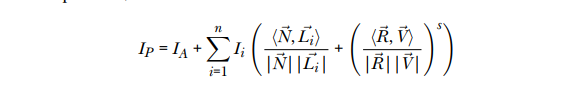